In [115]:
import pandas as pd
import numpy as np
import mibian
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as smf

In [2]:
OptionList = pd.read_csv("nifty_311221_070122_1min.csv",index_col=0)
OptionList.head()

,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry
index,,,,,,,,,,,,,
0,2021-12-31 09:15:00+05:30,493.10,5400,NIFTY22JAN17000CE,17311.0,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17000,CE,2021/12/31 9:15,27.260764
1,2021-12-31 09:15:00+05:30,82.95,0,NIFTY22JAN17850CE,17311.0,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17850,CE,2021/12/31 9:15,27.260764
2,2021-12-31 09:15:00+05:30,600.00,0,NIFTY22JAN17850PE,17311.0,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17850,PE,2021/12/31 9:15,27.260764
3,2021-12-31 09:15:00+05:30,74.95,3150,NIFTY22JAN17900CE,17311.0,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17900,CE,2021/12/31 9:15,27.260764
4,2021-12-31 09:15:00+05:30,631.20,0,NIFTY22JAN17900PE,17311.0,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17900,PE,2021/12/31 9:15,27.260764


In [3]:
# see reference: https://github.com/yassinemaaroufi/MibianLib
def calculateIV(row):
    s = row['fut_price']
    k = row['strike']
    r = 0
    t = row['days_to_expiry']
    price = row['opt_price']
    if row['instrument_type'] == 'CE':
        bs = mibian.BS([s,k,r,t],callPrice=price)
    elif row['instrument_type'] == 'PE':
        bs = mibian.BS([s,k,r,t],putPrice=price)
    return bs.impliedVolatility

In [4]:
def calculateDelta(row):
    s = row['fut_price']
    k = row['strike']
    r = 0
    t = row['days_to_expiry']
    v = row['IV']
    bs = mibian.BS([s,k,r,t],volatility=v)
    if row['instrument_type'] == 'CE':
        res = bs.callDelta
    elif row['instrument_type'] == 'PE':
        res = bs.putDelta
    return res

In [5]:
def calculateVega(row):
    s = row['fut_price']
    k = row['strike']
    r = 0
    t = row['days_to_expiry']
    v = row['IV']
    bs = mibian.BS([s,k,r,t],volatility=v)
    return bs.vega

In [6]:
callsATM = OptionList[(OptionList['instrument_type']=='CE')&(abs(OptionList['strike'] - OptionList['fut_price']) <= 25)]
callsATM.reset_index(inplace=True,drop=True)
callsATM.head()

,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry
0,2021-12-31 09:15:00+05:30,307.30,61500,NIFTY22JAN17300CE,17311.00,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17300,CE,2021/12/31 9:15,27.260764
1,2021-12-31 09:16:00+05:30,287.00,850,NIFTY22JAN17350CE,17332.10,191750,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:16,27.260069
2,2021-12-31 09:17:00+05:30,286.35,1000,NIFTY22JAN17350CE,17330.70,83200,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:17,27.259375
3,2021-12-31 09:18:00+05:30,288.10,800,NIFTY22JAN17350CE,17338.25,80850,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:18,27.258681
4,2021-12-31 09:19:00+05:30,287.50,1850,NIFTY22JAN17350CE,17335.00,64800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:19,27.257986


In [7]:
putsATM = OptionList[(OptionList['instrument_type']=='PE')&(abs(OptionList['strike'] - OptionList['fut_price']) <= 25)]
putsATM.reset_index(inplace=True,drop=True)
putsATM.head()

,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry
0,2021-12-31 09:15:00+05:30,292.9,43600,NIFTY22JAN17300PE,17311.00,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17300,PE,2021/12/31 9:15,27.260764
1,2021-12-31 09:16:00+05:30,305.1,50,NIFTY22JAN17350PE,17332.10,191750,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:16,27.260069
2,2021-12-31 09:17:00+05:30,302.0,900,NIFTY22JAN17350PE,17330.70,83200,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:17,27.259375
3,2021-12-31 09:18:00+05:30,303.0,200,NIFTY22JAN17350PE,17338.25,80850,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:18,27.258681
4,2021-12-31 09:19:00+05:30,305.1,150,NIFTY22JAN17350PE,17335.00,64800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:19,27.257986


In [8]:
%%time
callsATM['IV'] = callsATM.apply(calculateIV,axis=1)
#callsATM.head()

Wall time: 10.6 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
%%time
callsATM['delta'] = callsATM.apply(calculateDelta,axis=1)
#callsATM.head()

Wall time: 2.58 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
%%time
callsATM['vega'] = callsATM.apply(calculateVega,axis=1)
callsATM.head()

Wall time: 2.57 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
0,2021-12-31 09:15:00+05:30,307.30,61500,NIFTY22JAN17300CE,17311.00,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17300,CE,2021/12/31 9:15,27.260764,15.995026,0.514517,18.861105
1,2021-12-31 09:16:00+05:30,287.00,850,NIFTY22JAN17350CE,17332.10,191750,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:16,27.260069,15.647888,0.498900,18.896294
2,2021-12-31 09:17:00+05:30,286.35,1000,NIFTY22JAN17350CE,17330.70,83200,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:17,27.259375,15.653133,0.498153,18.894397
3,2021-12-31 09:18:00+05:30,288.10,800,NIFTY22JAN17350CE,17338.25,80850,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:18,27.258681,15.544891,0.502112,18.902325
4,2021-12-31 09:19:00+05:30,287.50,1850,NIFTY22JAN17350CE,17335.00,64800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,CE,2021/12/31 9:19,27.257986,15.602112,0.500412,18.898796


Wall time: 54 ms


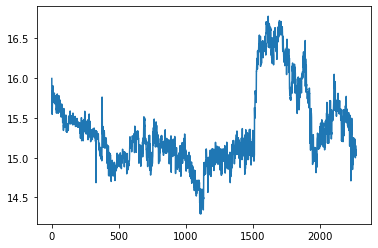

In [11]:
%%time
fig, ax = plt.subplots()
#ax.plot(callsATM['date'],callsATM['IV'])
ax.plot(callsATM['IV'])

In [12]:
%%time
putsATM['IV'] = putsATM.apply(calculateIV,axis=1)
#putsATM.head()

Wall time: 10.9 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
%%time
putsATM['delta'] = putsATM.apply(calculateDelta,axis=1)
#putsATM.head()

Wall time: 2.61 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
%%time
putsATM['vega'] = putsATM.apply(calculateVega,axis=1)
putsATM.head()

Wall time: 2.64 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
0,2021-12-31 09:15:00+05:30,292.9,43600,NIFTY22JAN17300PE,17311.00,174100,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17300,PE,2021/12/31 9:15,27.260764,15.815735,-0.485515,18.861160
1,2021-12-31 09:16:00+05:30,305.1,50,NIFTY22JAN17350PE,17332.10,191750,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:16,27.260069,15.663147,-0.501082,18.896297
2,2021-12-31 09:17:00+05:30,302.0,900,NIFTY22JAN17350PE,17330.70,83200,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:17,27.259375,15.460968,-0.502081,18.894342
3,2021-12-31 09:18:00+05:30,303.0,200,NIFTY22JAN17350PE,17338.25,80850,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:18,27.258681,15.712738,-0.497729,18.902283
4,2021-12-31 09:19:00+05:30,305.1,150,NIFTY22JAN17350PE,17335.00,64800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17350,PE,2021/12/31 9:19,27.257986,15.739441,-0.499443,18.898787


Wall time: 12 ms


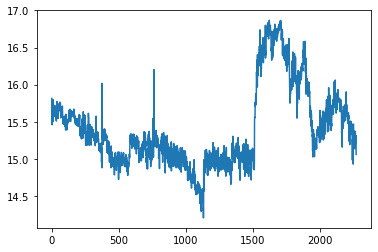

In [15]:
%%time
fig, ax = plt.subplots()
#ax.plot(putsATM['date'],callsATM['IV'])
ax.plot(putsATM['IV'])

### To be continue
#### 1. regression modelling on a time window of 24 hour
#### 2. test result in 1 hour
#### 3. looping in a function to finish in all available data sets

In [161]:
# starting point
tmp = callsATM.copy()
#tmp = putsATM.copy()
#start = '2021-12-31 09:15:00+05:30'
start = '2021-12-31 09:15:00+05:30'
train_start_index = tmp[tmp['date'] == start].index[0]
train_window_length = 375*4 #375
train_end_index = train_start_index+train_window_length
tmp = tmp.iloc[train_start_index:train_end_index]
## normalize the option price change and future price change
tmp['opt_price_chg'] = tmp['opt_price'].diff()
tmp['fut_price_chg'] = tmp['fut_price'].diff()
#tmp['opt_price_chg'] = tmp['opt_price'] / tmp['opt_price'].shift()
#tmp['fut_price_chg'] = tmp['fut_price'] / tmp['fut_price'].shift()

tmp = tmp[tmp['fut_price_chg']!=0] # note: this line to remove 2 ATM option with same fut_price at the same time
tmp = tmp[['ts','opt_price_chg','fut_price_chg','delta','vega','days_to_expiry','fut_price']]
tmp.reset_index(drop=True,inplace=True)
train_set = pd.DataFrame()
train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])*np.sqrt(tmp['days_to_expiry'])/tmp['vega']*tmp['fut_price']/tmp['fut_price_chg']
train_set['x1'] = tmp['delta']
train_set['x2'] = tmp['delta']**2
train_set.drop(index=0,inplace=True)
train_set

,y,x1,x2
1,-6996.550325,0.498900,0.248902
2,-162.188271,0.498153,0.248156
3,-1294.572141,0.502112,0.252116
4,-1512.320656,0.500412,0.250412
5,1668.703664,0.503413,0.253424
...,...,...,...
1461,-2493.440156,0.520015,0.270415
1462,-4599.110888,0.519249,0.269620
1463,-2496.177609,0.520550,0.270972
1464,-867.144037,0.517439,0.267743


In [162]:
# train multi-linear-regression
x = sm.add_constant(train_set.iloc[:,1:])
y = train_set['y']
model = sm.OLS(y,x)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     50.08
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           9.22e-22
Time:                        16:58:32   Log-Likelihood:                -16647.
No. Observations:                1465   AIC:                         3.330e+04
Df Residuals:                    1462   BIC:                         3.332e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.157e+07   2.17e+06     -9.918      0.000   -2.58e+07   -1.73e+07
x1          8.488e+07   8.57e+06      9.906      0.000    6.81e+07    1.02e+08
x2         -8.351e+07   8.44e+06     -9.895      0.000      -1e+08    -6.7e+07
==============================================================================
Omnibus:                     1747.609   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           806733.121
Skew:                          -5.524   Prob(JB):                         0.00
Kurtosis:                     117.429   Cond. No.                     2.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [163]:
# in sample predict
y_pred = result.predict(x)
y_pred

1      -4505.549758
2      -5717.291530
3       -361.386541
4      -2340.342732
5        827.422184
           ...     
1461   -8824.417476
1462   -7367.603724
1463   -9901.755646
1464   -4310.011913
1465    -795.947277
Length: 1465, dtype: float64

In [164]:
# calcualte MV delta
tmp = callsATM.copy()
test_start_index = train_end_index
test_window_length = 24
test_end_index = test_start_index + test_window_length
tmp = tmp.iloc[test_start_index:test_end_index]
tmp = tmp[['ts','delta','vega','days_to_expiry','fut_price']]
b0 = result.params[0]
b1 = result.params[1]
b2 = result.params[2]
tmp['y_hat'] = b0+b1*tmp['delta']+b2*tmp['delta']**2
tmp['MV_delta'] = tmp['delta']+tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry'])*(b0+b1*tmp['delta']+b2*tmp['delta']**2)
tmp

,ts,delta,vega,days_to_expiry,fut_price,y_hat,MV_delta
1500,2022/1/5 15:18,0.513658,17.584226,22.008681,17960.45,310.009895,0.578355
1501,2022/1/5 15:19,0.512350,17.583675,22.007986,17958.25,1352.232985,0.794582
1502,2022/1/5 15:20,0.512414,17.583456,22.007292,17958.40,1307.358991,0.785280
1503,2022/1/5 15:21,0.508573,17.581367,22.006597,17952.00,2757.931556,1.084340
1504,2022/1/5 15:22,0.505813,17.578777,22.005903,17947.40,2278.780826,0.981609
1505,2022/1/5 15:23,0.503608,17.576023,22.005208,17943.70,981.292631,0.708509
1506,2022/1/5 15:24,0.505785,17.578240,22.004514,17947.40,2267.388720,0.979202
1507,2022/1/5 15:25,0.508208,17.580056,22.003819,17951.45,2767.550367,1.085995
1508,2022/1/5 15:26,0.509109,17.580386,22.003125,17952.95,2703.419808,1.073479
1509,2022/1/5 15:27,0.511566,17.581267,22.002431,17957.00,1839.576210,0.895538


In [74]:
callsATM[(callsATM['date']>'2022-01-02 15:30')&(callsATM['date']<='2022-01-03 15:30')]

,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
375,2022-01-03 09:15:00+05:30,287.05,1550,NIFTY22JAN17450CE,17458.20,146600,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17450,CE,2022/1/3 9:15,24.260764,15.761375,0.512716,17.947115
376,2022-01-03 09:16:00+05:30,270.70,77200,NIFTY22JAN17500CE,17479.05,98550,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17500,CE,2022/1/3 9:16,24.260069,15.625000,0.496172,17.976597
377,2022-01-03 09:17:00+05:30,270.30,53900,NIFTY22JAN17500CE,17488.00,92250,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17500,CE,2022/1/3 9:17,24.259375,15.354156,0.500983,17.986318
378,2022-01-03 09:18:00+05:30,275.00,29650,NIFTY22JAN17500CE,17498.00,68650,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17500,CE,2022/1/3 9:18,24.258681,15.335083,0.506732,17.993837
379,2022-01-03 09:19:00+05:30,278.10,28250,NIFTY22JAN17500CE,17505.65,56950,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17500,CE,2022/1/3 9:19,24.257986,15.293121,0.511129,17.997004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,2022-01-03 15:25:00+05:30,261.75,3350,NIFTY22JAN17700CE,17683.05,104600,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17700,CE,2022/1/3 15:25,24.003819,14.925957,0.497649,18.090620
751,2022-01-03 15:26:00+05:30,263.75,8250,NIFTY22JAN17700CE,17685.00,45800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17700,CE,2022/1/3 15:26,24.003125,14.983177,0.498861,18.092593
752,2022-01-03 15:27:00+05:30,265.40,5050,NIFTY22JAN17700CE,17687.80,62800,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17700,CE,2022/1/3 15:27,24.002431,14.999390,0.500521,18.095254
753,2022-01-03 15:28:00+05:30,266.00,3300,NIFTY22JAN17700CE,17688.05,69500,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17700,CE,2022/1/3 15:28,24.001736,15.022278,0.500690,18.095237


In [34]:
callsATM[(callsATM['date']>'2021-12-31 15:30')&(callsATM['date']<'2022-01-01 15:30')]

,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
index,,,,,,,,,,,,,,,,


In [54]:
tmp['fut_price_chg'].describe()

count    740.000000
mean       0.563716
std        4.614811
min      -19.500000
25%       -2.012500
50%        0.300000
75%        3.000000
max       38.200000
Name: fut_price_chg, dtype: float64

In [46]:
callsATM[(callsATM['date']>'2022-01-02 15:30')&(callsATM['date']<'2022-01-03 15:30')&(abs(OptionList['strike'] - OptionList['fut_price']) == 25)]

<ipython-input-46-c5e84ca08f04>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  callsATM[(callsATM['date']>'2022-01-02 15:30')&(callsATM['date']<'2022-01-03 15:30')&(abs(OptionList['strike'] - OptionList['fut_price']) == 25)]


,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
index,,,,,,,,,,,,,,,,
36414,2022-01-03 12:20:00+05:30,256.00,5750,NIFTY22JAN17600CE,17575.0,18400,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17600,CE,2022/1/3 12:20,24.132292,14.873505,0.492801,18.025509
36478,2022-01-03 12:20:00+05:30,283.90,450,NIFTY22JAN17550CE,17575.0,18400,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17550,CE,2022/1/3 12:20,24.132292,15.052795,0.522381,18.000066
40225,2022-01-03 13:16:00+05:30,260.00,600,NIFTY22JAN17650CE,17625.0,12600,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17650,CE,2022/1/3 13:16,24.093403,15.064240,0.493110,18.062467
40240,2022-01-03 13:16:00+05:30,287.85,4800,NIFTY22JAN17600CE,17625.0,12600,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17600,CE,2022/1/3 13:16,24.093403,15.244007,0.522259,18.037033
41029,2022-01-03 13:28:00+05:30,260.00,0,NIFTY22JAN17650CE,17625.0,9150,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17650,CE,2022/1/3 13:28,24.085069,15.068054,0.493112,18.059344
41054,2022-01-03 13:28:00+05:30,288.30,5450,NIFTY22JAN17600CE,17625.0,9150,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17600,CE,2022/1/3 13:28,24.085069,15.274048,0.522248,18.033944
47435,2022-01-03 15:03:00+05:30,288.45,400,NIFTY22JAN17650CE,17675.0,43950,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17650,CE,2022/1/3 15:03,24.019097,15.257359,0.522223,18.060380
47474,2022-01-03 15:03:00+05:30,260.65,6750,NIFTY22JAN17700CE,17675.0,43950,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17700,CE,2022/1/3 15:03,24.019097,15.080929,0.493142,18.085779
48253,2022-01-03 15:15:00+05:30,283.05,1450,NIFTY22JAN17650CE,17675.0,45450,NIFTY22JANFUT,NIFTY,2022/1/27 15:30,17650,CE,2022/1/3 15:15,24.010764,14.961243,0.522358,18.056905


In [190]:
train_set['y'].describe()

count      1957.000000
mean      -3199.980774
std       20672.399686
min     -396498.713170
25%       -2485.232938
50%        -594.151759
75%         732.525928
max      261254.296673
Name: y, dtype: float64

In [187]:
tmp[tmp['fut_price_chg']!=0]

,ts,opt_price_chg,fut_price_chg,delta,vega,days_to_expiry,fut_price
0,2021/12/31 9:15,NaN,NaN,0.514517,18.861105,27.260764,17311.00
1,2021/12/31 9:16,-20.30,21.10,0.498900,18.896294,27.260069,17332.10
2,2021/12/31 9:17,-0.65,-1.40,0.498153,18.894397,27.259375,17330.70
3,2021/12/31 9:18,1.75,7.55,0.502112,18.902325,27.258681,17338.25
4,2021/12/31 9:19,-0.60,-3.25,0.500412,18.898796,27.257986,17335.00
...,...,...,...,...,...,...,...
1995,2022/1/7 10:58,2.80,5.25,0.510261,16.794002,20.189236,17905.00
1996,2022/1/7 10:59,0.20,5.00,0.513356,16.794544,20.188542,17910.00
1997,2022/1/7 11:00,-1.80,-6.75,0.509161,16.792912,20.187847,17903.25
1998,2022/1/7 11:01,-3.10,-5.00,0.506029,16.790443,20.187153,17898.25
